# Notebook 3 — Volatility Smile & Stochastic Models

The Black-Scholes model assumes constant volatility, yet market option prices imply a **strike-dependent** and **maturity-dependent** volatility — the *volatility smile* (or *smirk*). This notebook explores:

1. Building a **synthetic implied-vol surface** from a toy parametric model
2. Visualising the IV surface, call-price surface, total-variance surface, and vega surface
3. Recovering the smile from **Local Volatility** Monte Carlo paths
4. Recovering the smile from **Heston** stochastic-volatility paths
5. Comparing all three smile shapes on a single plot
6. Round-trip verification: price $\to$ implied vol $\to$ price

In [12]:
# Core imports
import numpy as np
import math
import matplotlib.pyplot as plt

# 3D plotting
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

# Your package
import optpricer as op
from optpricer.processes import local_vol_paths, heston_paths

# Reproducibility
rng = np.random.default_rng(42)

# Matplotlib defaults (keep it simple)
plt.rcParams["figure.figsize"] = (7.5, 5.0)
plt.rcParams["axes.grid"] = True


In [13]:
def forward_price(S0, r, q, T):
    """Forward price F(0,T) under continuous rates/yield."""
    return S0 * math.exp((r - q) * T)

def synthetic_iv(K, T, S0=100.0, r=0.03, q=0.0):
    """
    A toy, arbitrage-friendly-ish IV model:
      σ_imp(k, T) = (a0 + a1*sqrt(T)) * (1 + b1*|k| + b2*k)
    where k = ln(K/F). Choose small slopes to keep convexity mostly sane.
    """
    F = forward_price(S0, r, q, T)
    k = np.log(np.asarray(K) / F)
    a0, a1 = 0.16, 0.06     # term structure (base + term premium)
    b1, b2 = 0.35, -0.15    # smile curvature & skew (smirk)
    base = a0 + a1 * np.sqrt(T)
    smile = (1.0 + b1 * np.abs(k) + b2 * k)
    sigma = np.maximum(1e-4, base * smile)
    return sigma

def meshgrid_strikes_tenors(S0=100.0):
    """Build strike and tenor grids centered around ATM forward."""
    Ts = np.array([0.1, 0.25, 0.5, 1.0, 2.0])         # in years
    Ks = np.linspace(60, 140, 33)                     # strikes
    return Ks, Ts

def bs_price_surface(S0, r, q, Ks, Ts, iv_fn):
    """Compute price, implied-vol, and total-variance surfaces on (K,T) grid."""
    IV = np.zeros((len(Ts), len(Ks)))
    PRICE = np.zeros_like(IV)
    W = np.zeros_like(IV)  # total variance = sigma^2 * T
    for i, T in enumerate(Ts):
        for j, K in enumerate(Ks):
            sig = float(iv_fn(K, T, S0=S0, r=r, q=q))  # synthetic smile
            IV[i, j] = sig
            W[i, j] = sig * sig * T
            spec = op.OptionSpec(S0=S0, K=K, T=T, r=r, sigma=sig, q=q)
            PRICE[i, j] = op.bs_price(spec, op.CALL)  # call surface
    return PRICE, IV, W


## Setup & Synthetic Smile Model

We define a parametric implied-vol function $\sigma_{\text{impl}}(K, T)$ with:
- A **term structure** component: base vol increases with $\sqrt{T}$ (a simple premium for longer tenors)
- A **smile/skew** component: OTM puts ($K < F$) have higher IV than OTM calls ($K > F$)

The function `bs_price_surface` evaluates the BS formula on a $(K, T)$ grid using this smile to produce price, IV, and total-variance surfaces.

In [14]:
S0, r, q = 100.0, 0.03, 0.0
Ks, Ts = meshgrid_strikes_tenors(S0=S0)

PRICE, IV, W = bs_price_surface(S0, r, q, Ks, Ts, synthetic_iv)

print("Surfaces computed:")
print("PRICE shape:", PRICE.shape, "IV shape:", IV.shape, "W shape:", W.shape)


Surfaces computed:
PRICE shape: (5, 33) IV shape: (5, 33) W shape: (5, 33)


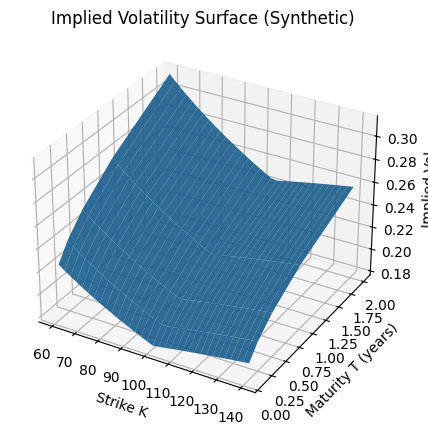

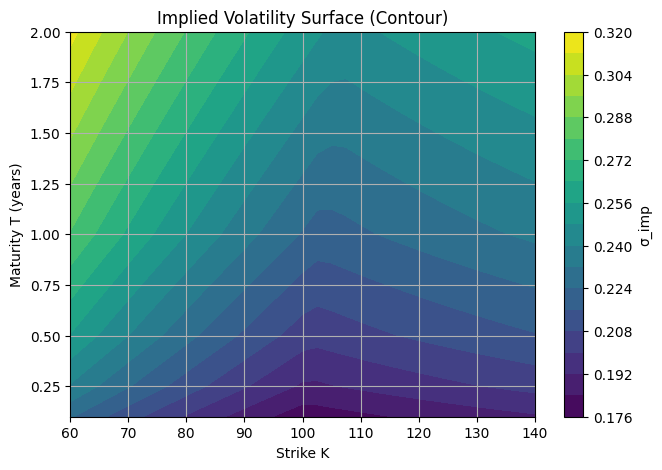

In [15]:
# 3D surface for IV(K,T)
Kmesh, Tmesh = np.meshgrid(Ks, Ts)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Kmesh, Tmesh, IV, linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T (years)")
ax.set_zlabel("Implied Vol")
ax.set_title("Implied Volatility Surface (Synthetic)")
plt.show()

# Contour view (often easier to read)
plt.figure()
cs = plt.contourf(Kmesh, Tmesh, IV, levels=16)
plt.xlabel("Strike K"); plt.ylabel("Maturity T (years)")
plt.title("Implied Volatility Surface (Contour)")
plt.colorbar(cs, label="σ_imp")
plt.show()


## 1. Implied Volatility Surface

Two views of the same surface: a 3D mesh (intuitive) and a filled contour plot (easier to read precise values). Notice the characteristic equity-market **skew** — lower strikes carry higher implied vol.

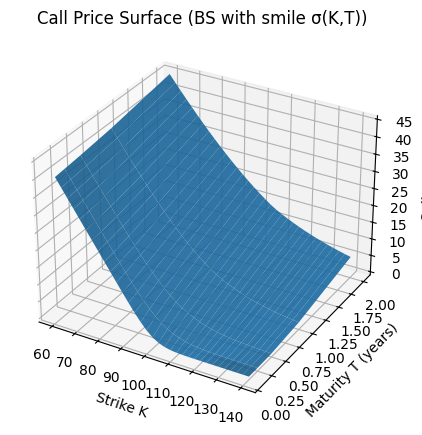

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Kmesh, Tmesh, PRICE, linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T (years)")
ax.set_zlabel("Call Price")
ax.set_title("Call Price Surface (BS with smile σ(K,T))")
plt.show()


## 2. Call Price Surface

The BS call price surface generated with the strike-dependent volatility above. Compared to a flat-vol surface, the skew inflates deep-OTM put prices (equivalently, deep-ITM calls via parity) and deflates OTM call prices.

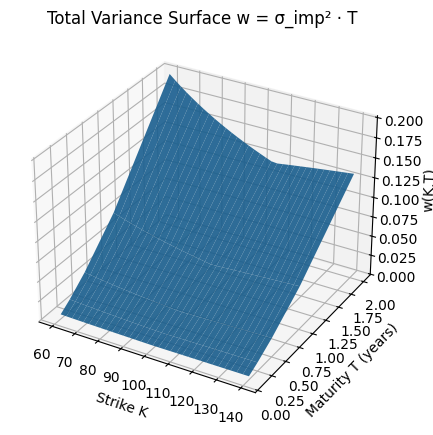

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Kmesh, Tmesh, W, linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel("Strike K"); ax.set_ylabel("Maturity T (years)"); ax.set_zlabel("w(K,T)")
ax.set_title("Total Variance Surface w = σ_imp² · T")
plt.show()


## 3. Total Variance Surface $w(K, T) = \sigma_{\text{impl}}^2 \cdot T$

Total variance is the natural quantity for SVI calibration. A well-behaved surface should be **monotonically increasing in $T$** for every fixed $K$ (calendar-spread arbitrage condition) and **convex in $K$** for every fixed $T$ (butterfly arbitrage condition).

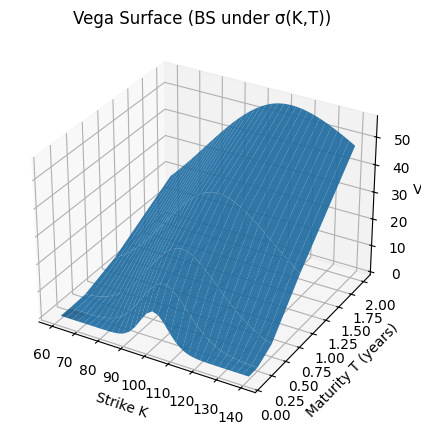

In [18]:
VEGA = np.zeros_like(IV)
for i, T in enumerate(Ts):
    for j, K in enumerate(Ks):
        spec = op.OptionSpec(S0=S0, K=K, T=T, r=r, sigma=IV[i, j], q=q)
        g = op.bs_greeks(spec, op.CALL)
        VEGA[i, j] = g["vega"]  # dPrice / dSigma (sigma in absolute units)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Kmesh, Tmesh, VEGA, linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel("Strike K"); ax.set_ylabel("Maturity T (years)"); ax.set_zlabel("Vega")
ax.set_title("Vega Surface (BS under σ(K,T))")
plt.show()


## 4. Vega Surface

Vega ($\partial V / \partial \sigma$) measures sensitivity to implied-vol changes. It peaks at ATM and at longer maturities. Traders use vega to size vol bets and to assess P&L exposure from smile movements.

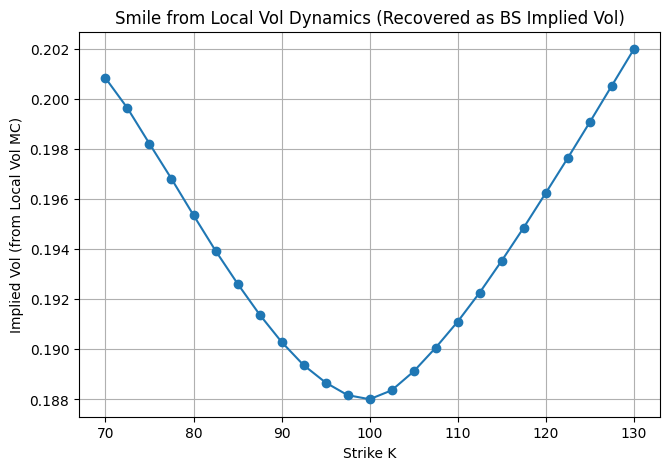

In [19]:
# A toy local-vol function that increases away from ATM (around S=100).
def sigma_loc_toy(S_vec, t):
    base, slope = 0.18, 0.0015
    return base + slope * np.abs(S_vec - 100.0)

# Price a 1Y call across strikes under Local Vol via MC, then recover IV by root-finding
T_mc = 1.0
n_steps, n_paths = 252, 80_000

S_paths = local_vol_paths(S0=S0, r=r, q=q, T=T_mc, n_steps=n_steps, n_paths=n_paths,
                          sigma_loc=sigma_loc_toy, seed=123)
ST = S_paths[-1]
disc = math.exp(-r * T_mc)

K_grid = np.linspace(70, 130, 25)
prices_lv = []
iv_lv = []
for K in K_grid:
    payoff = np.maximum(ST - K, 0.0)
    price = disc * payoff.mean()
    prices_lv.append(price)
    # Invert to implied vol in BS with the SAME (S0, r, q, T)
    spec = op.OptionSpec(S0=S0, K=K, T=T_mc, r=r, sigma=0.2, q=q)
    iv = op.implied_vol(spec, target_price=price, kind=op.CALL)
    iv_lv.append(iv)

prices_lv = np.array(prices_lv)
iv_lv = np.array(iv_lv)

plt.figure()
plt.plot(K_grid, iv_lv, marker="o")
plt.xlabel("Strike K"); plt.ylabel("Implied Vol (from Local Vol MC)")
plt.title("Smile from Local Vol Dynamics (Recovered as BS Implied Vol)")
plt.show()


## 5. Smile from Local Volatility Dynamics

We define a toy local-vol function $\sigma_{\text{loc}}(S, t) = 0.18 + 0.0015 \cdot |S - 100|$ and simulate 80,000 paths via `local_vol_paths`. For each strike, we compute the MC call price and then **invert** it through the BS formula to recover the implied vol.

The resulting smile is generated *endogenously* by the local-vol dynamics — it is not plugged in by hand.

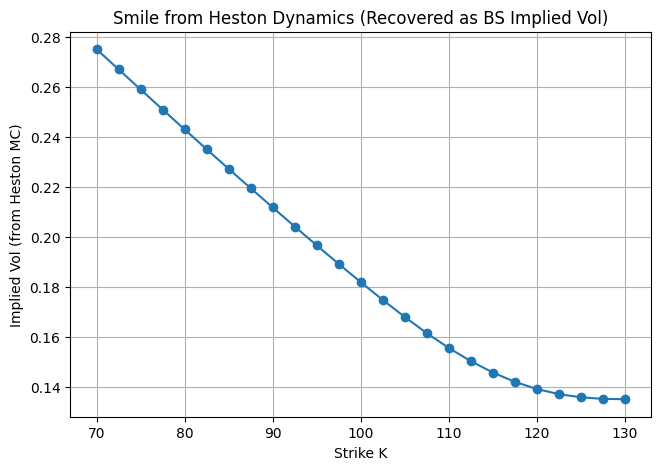

In [20]:
# Heston parameters (choose something that produces a left-skewed smile)
v0, kappa, theta, xi, rho = 0.04, 1.5, 0.04, 0.6, -0.7
T_mc = 1.0
n_steps, n_paths = 252, 100_000

S_paths = heston_paths(S0=S0, r=r, q=q, v0=v0, kappa=kappa, theta=theta, xi=xi, rho=rho,
                       T=T_mc, n_steps=n_steps, n_paths=n_paths, seed=321)
ST = S_paths[-1]
disc = math.exp(-r * T_mc)

K_grid = np.linspace(70, 130, 25)
prices_heston = []
iv_heston = []
for K in K_grid:
    payoff = np.maximum(ST - K, 0.0)
    price = disc * payoff.mean()
    prices_heston.append(price)
    spec = op.OptionSpec(S0=S0, K=K, T=T_mc, r=r, sigma=0.2, q=q)
    iv = op.implied_vol(spec, target_price=price, kind=op.CALL)
    iv_heston.append(iv)

prices_heston = np.array(prices_heston)
iv_heston = np.array(iv_heston)

plt.figure()
plt.plot(K_grid, iv_heston, marker="o")
plt.xlabel("Strike K"); plt.ylabel("Implied Vol (from Heston MC)")
plt.title("Smile from Heston Dynamics (Recovered as BS Implied Vol)")
plt.show()


## 6. Smile from Heston Stochastic Volatility

The Heston model generates a smile via **stochastic variance** with mean reversion ($\kappa$), vol-of-vol ($\xi$), and spot-vol correlation ($\rho$). With $\rho = -0.7$ (strong negative correlation), the smile exhibits a pronounced left skew — consistent with the leverage effect seen in equity markets.

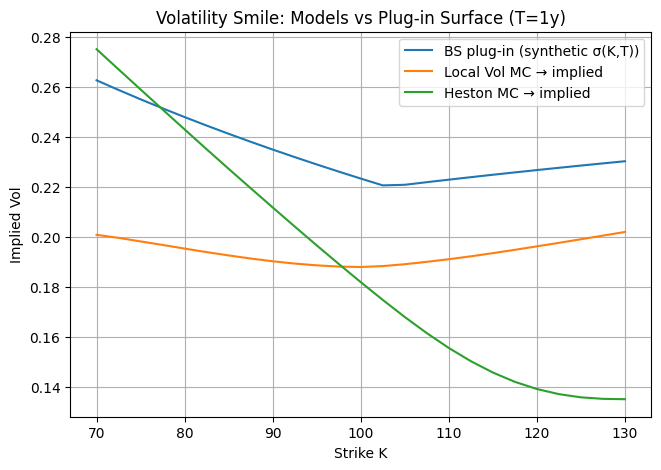

In [21]:
# BS plug-in IV at T=1 from the synthetic surface:
iv_bs = np.array([synthetic_iv(K, 1.0, S0=S0, r=r, q=q) for K in K_grid])

plt.figure()
plt.plot(K_grid, iv_bs, label="BS plug-in (synthetic σ(K,T))")
plt.plot(K_grid, iv_lv, label="Local Vol MC → implied")
plt.plot(K_grid, iv_heston, label="Heston MC → implied")
plt.xlabel("Strike K"); plt.ylabel("Implied Vol")
plt.title("Volatility Smile: Models vs Plug-in Surface (T=1y)")
plt.legend()
plt.show()


## 7. Smile Comparison — Three Models

All three smile generators plotted on the same axes:
- **BS plug-in**: the parametric smile we defined at the start (deterministic)
- **Local Vol MC**: smile emerging from a state-dependent $\sigma(S,t)$
- **Heston MC**: smile emerging from stochastic variance

Each model produces a different smile shape from fundamentally different dynamics. In practice, the choice of model depends on the asset class, the instruments being priced, and the hedging strategy.

Max |IV_rec - IV| over grid: 0.000045


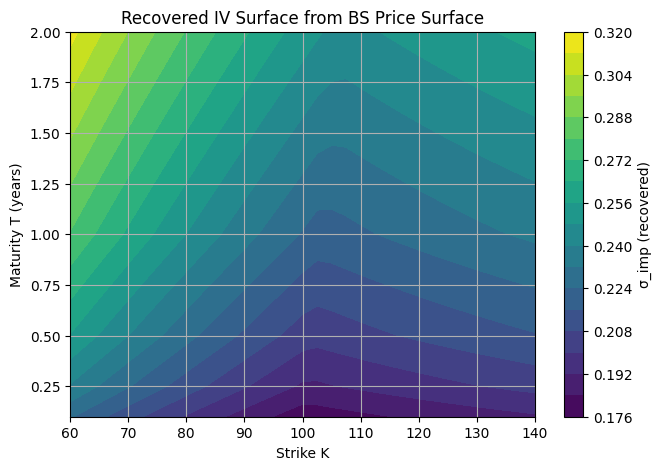

In [22]:
# Recover an IV *surface* from the BS price surface (sanity check round-trip)
IV_rec = np.zeros_like(IV)
for i, T in enumerate(Ts):
    for j, K in enumerate(Ks):
        spec = op.OptionSpec(S0=S0, K=K, T=T, r=r, sigma=0.2, q=q)
        IV_rec[i, j] = op.implied_vol(spec, target_price=PRICE[i, j], kind=op.CALL)

# Quick check: should be very close to the original IV surface
diff = np.max(np.abs(IV_rec - IV))
print(f"Max |IV_rec - IV| over grid: {diff:.6f}")

plt.figure()
cs = plt.contourf(Kmesh, Tmesh, IV_rec, levels=16)
plt.xlabel("Strike K"); plt.ylabel("Maturity T (years)")
plt.title("Recovered IV Surface from BS Price Surface")
plt.colorbar(cs, label="σ_imp (recovered)")
plt.show()


## 8. Round-Trip Verification

A sanity check: take the BS prices generated from the synthetic smile, invert each one via `implied_vol`, and compare the recovered IV to the original. The maximum absolute difference should be at machine precision ($\sim 10^{-6}$), confirming that the implied-vol solver is accurate.